# Module 6: Descriptive and Predictive Modeling

### Work performed by:
#### Rafael Haba Díaz 79030459K
#### Hugo Puerto Rosello 76884689J

## Exercise 1: K-Nearest Neighbors in depth

### In this case, we have chosen the digits dataset (Advanced)

In [3]:
#Importing Libraries
from sklearn.datasets import load_digits
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from time import time
import collections

### Importing X, y from the digits dataset

In [4]:
X, y = load_digits(return_X_y = True)

## 1) Describe the dataset in dimensions such as number of features, number of categories, and number of samples per category using Python.

In [5]:
Categories = list(set(y))
SamplesCategories = collections.Counter(y) #Samples per Category   
Features = len(X[0, :]) #Features

In [6]:
print("Categories:"+ str(Categories) +"\n"+"Samples per category: "+str(SamplesCategories)+"\n"+"Features: "+str(Features))

Categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Samples per category: Counter({3: 183, 1: 182, 5: 182, 4: 181, 6: 181, 9: 180, 7: 179, 0: 178, 2: 177, 8: 174})
Features: 64


## 2) Represent the statistical support of every feature graphically, resorting to Matplotlib’s boxplot function.Are there any outliers that can be detected by simple visual inspection? If so, devise a handcrafted method to detect and isolate such examples.

In [7]:
#Function for drawing the boxplots 
def boxplot(X):   
    fig, axs = plt.subplots(2, 2)
    
    axs[0,0].boxplot(X[0:, 0:16])
    axs[0,0].set_xlabel("pixel")
    axs[0,0].set_ylabel("Black Level")
    
    axs[0,1].boxplot(X[0:,16:32])
    axs[0,1].set_xlabel("Pixel")
    axs[0,1].set_ylabel("Black Level")
    
    axs[1,0].boxplot(X[0:,32:48])
    axs[1,0].set_xlabel("Pixel")
    axs[1,0].set_ylabel("Black Level")
    
    axs[1,1].boxplot(X[0:,48:64])
    axs[1,1].set_xlabel("Pixel")
    axs[1,1].set_ylabel("Black Level")
    
    
    plt.subplots_adjust(left=0.125,
                        bottom=0.1, 
                        right= 1.2, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.35)
    plt.show()

 As we can see in the next figure (boxplot), where the x-axis represents a pixel and the y-axis represents a black level, there are some outliers, specially in those pixels that are in corners and have low black levels. This subplot represents pixels (1-16) in the high left figure, pixels (17-32) high-right figure, pixels(33-48) down-left figure, pixels(49-64) down-right figure.

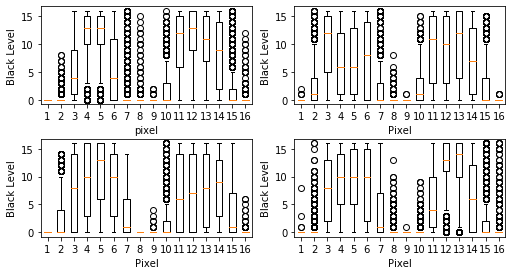

In [8]:
boxplot(X)

So, after identifying outliers, the next step is trying to isolate and delete them. In this case, we think that a solution could be finding the extreme of every box whisker and changing the value of every outlier to this value.

In [12]:
df = DataFrame (X)
#Function for correcting the outliers
def outliers_correction():
    q3 = df.quantile(0.75)
    q1 = df.quantile(0.25)
    
    ir = (q3 - q1)*1.5
    
    vmin = q1 - ir 
    vmin = vmin.tolist()
    vmax = q3 + ir
    vmax = vmax.tolist()
    
    for j in range(len(X)):
        for i in range(len(X[0,:])):
            if X[j,i] < vmin[i] and vmin[i] >= 0:        
                X[j, i] = vmin[i]
            elif X[j,i] < vmin[i] and vmin[i] < 0:
                X[j, i] = 0
            elif X[j, i] > vmax[i]:
                X[j,i] = vmax[i]

After correcting outliers, we have the next boxplot. As we can see, there are lots of pixels with 0 black level, as we have said before, those pixels correspond to corners, where the number is not drawn and consequently the black level is 0. 

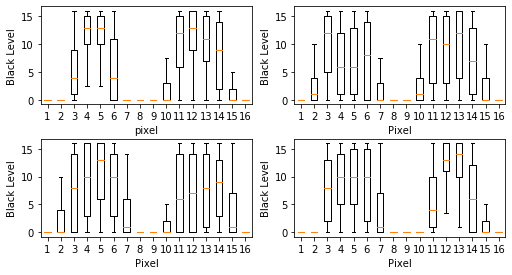

In [15]:
outliers_correction()
boxplot(X)
df = DataFrame (X)

## 3) Repeat each of the experiments seen in class with the K-Nearest Neighbors model, providing arguments for each of the steps taken along the process, and commenting on the partial results obtained with the selected dataset. Please use as many performance metrics as needed to illustrate the particularities of the selected dataset (e.g. imbalanced classes).

Answered in the following questions.

## 4) Read the Scikit-learn library documentation and configure the automated validation script so that theGridSearchCV() function uses leave-one-out cross-validation instead of k-fold. Which conclusions can be drawn from the mean cross-validation scores and the test scores using a k-neighbor model with optimized k?

At first, we think that could be interesting to explain what function "loo" does. In this case, the first step is making an object from the class LeaveOneOut(), because we are going to use it later in the GridSearchCv. After that, we make an StratifiedSuffleSplit in order of making partitions in training an test and also having similar samples of  every category (balanced). After that, we do the GridSearchCV using the LeaveOneOut cv.

Leave One Out Crossvalidation uses all samples for training except one that is going to use for testing. It means that  it has to make as many iterations as samples we have. There are some reasons for not using it, obviously computing costs is one of them, making n iterations in datasets with a great deal of samples, does not sound very well, but maybe the most dangerous thing about this crossvalidation method is the overfitting, making trainings with all the dataset and then testing with only one sample is the best friend of overfitting.

In [24]:
#Function for Leave-One-Out (verbose = 2 non activated to see only results)
def loo(n_neighbors, weights, p, n_splits, test_size, random_state):  
    loo = LeaveOneOut()
    sss = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    miModelo = KNeighborsClassifier()
    params = {'n_neighbors':n_neighbors,'weights':weights,'p':p}
    gs = GridSearchCV(estimator=miModelo,param_grid=params,scoring='accuracy',cv=loo)#, verbose = 2)
    gs.fit(X_train,y_train)
    resultsCV = gs.cv_results_
    
    clfBest = gs.best_estimator_
    clfBest.fit(X_train,y_train)
    
    y_pred = clfBest.predict(X_test)
    
    #plot confusion matrix
    fig,ax = plt.subplots(figsize = (15,15))
    disp = plot_confusion_matrix(clfBest, X_test, y_test, ax = ax)
    
    #plot confusion matrix
    disp.ax_.set_title("Confusion matrix, using Loo")
    plt.show()
    
    
    accuracyLoo = accuracy_score(y_test, y_pred)
    f1ScoreLoo = f1_score(y_test, y_pred,average = 'macro')
    recallLoo = recall_score(y_test, y_pred,average = 'macro')
    precisionLoo = precision_score(y_test, y_pred, average = 'macro')
    
      
    ocurrenciasLoo = collections.Counter(y_train)
    print("------------------------")
    print("ClfBest Loo: "+ str(clfBest))
    print("------------------------")
    print("Accuracy Loo: "+ str(accuracyLoo))
    print("f1Score Loo: "+ str(f1ScoreLoo))
    print("recall Loo: "+ str(recallLoo))
    print("precision Loo: "+ str(precisionLoo))
    print("Ocurrencias Loo: " + str(ocurrenciasLoo))
    print("------------------------")

As we can see in the next confusion matrix, there are not many samples confused, it means that error is very low, as we can see in the scores bellow (accuracy, f1score, recall and precision). It is also very important and remarkable, saying that we have made an stratified crossvalidation, so samples for every category are balanced, having a non balanced train set and then using this type of crossvalidation is not the best option, regarding that we are training with all samples with an exception of one that is going to be the tested. Also remarkable the high execution time. 

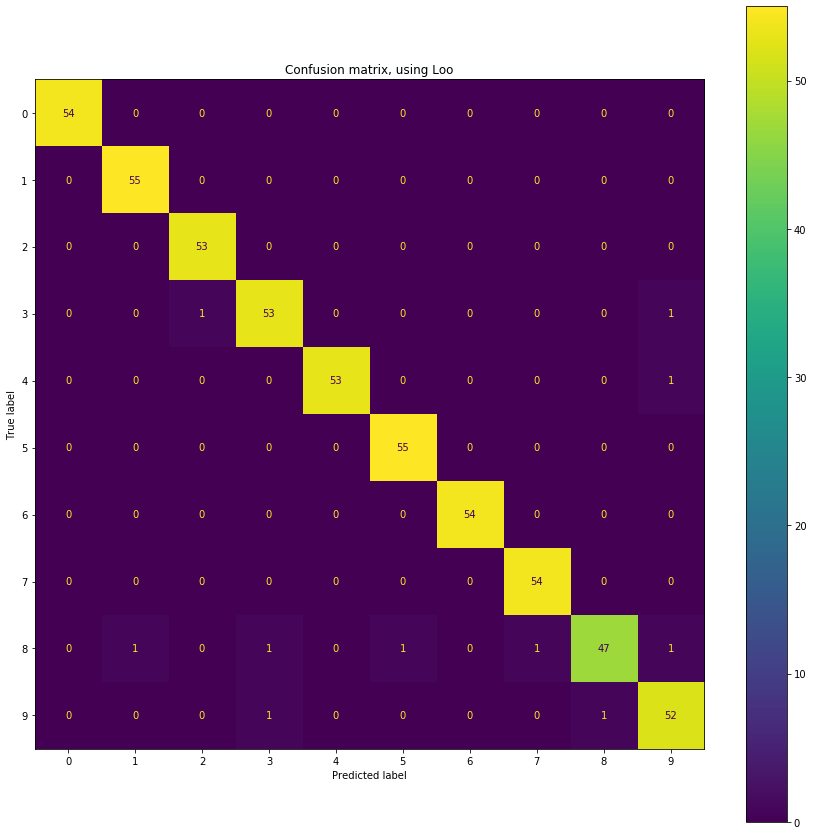

------------------------
ClfBest Loo: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
------------------------
Accuracy Loo: 0.9814814814814815
f1Score Loo: 0.9811880885273665
recall Loo: 0.9811926961926962
precision Loo: 0.9815842953342953
Ocurrencias Loo: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [25]:
#loo(n_neighbors, weights, p, n_splits, test_size, random_state)
loo([3], ['uniform'], [2],1, 0.3, 13)

## 5) Elaborate on the need for stratifying the cross-validation process analyzing the distribution of samples by class. If so, please show with empirical evidence what could occur if such a stratification was not performed, specially when decreasing the number of samples of the dataset

In [26]:
def KNN_Stratified_CV(n_splits, test_size, random_state, n_neighbors, weights, p, cv):
    sss = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
           
    params = {'n_neighbors':n_neighbors,'weights':weights}
    miModelo = KNeighborsClassifier()
    gs = GridSearchCV(estimator=miModelo,param_grid=params,scoring='accuracy',cv=cv) #verbose=2)
    
    gs.fit(X_train,y_train)
    resultsCV = gs.cv_results_
    
    clfBest = gs.best_estimator_
    clfBest.fit(X_train,y_train)
    
    y_pred = clfBest.predict(X_test)
    
    #plot confusion matrix
    fig,ax = plt.subplots(figsize = (15,15))
    disp = plot_confusion_matrix(clfBest, X_test, y_test, ax = ax)
    
    #plot confusion matrix
    disp.ax_.set_title("Confusion matrix, using stratification and CV")
    plt.show()
    
    
    accuracyStratifiedCV = accuracy_score(y_test, y_pred)
    f1ScoreStratifiedCV = f1_score(y_test, y_pred,average = 'macro')
    recallStratifiedCV = recall_score(y_test, y_pred,average = 'macro')
    precisionStratifiedCV = precision_score(y_test, y_pred,average = 'macro')
      
    ocurrenciasStratifiedCV = collections.Counter(y_train)
    
    print("------------------------")
    print("Best Classifier: "+str(clfBest))
    print("Accuracy StratifiedCV: "+ str(accuracyStratifiedCV))   
    print("f1Score StratifiedCV: "+ str(f1ScoreStratifiedCV))
    print("recall StratifiedCV: "+ str(recallStratifiedCV))
    print("precision StratifiedCV: "+ str(precisionStratifiedCV))
    print("Ocurrencias StratifiedCV: " + str(ocurrenciasStratifiedCV))
    print("------------------------")

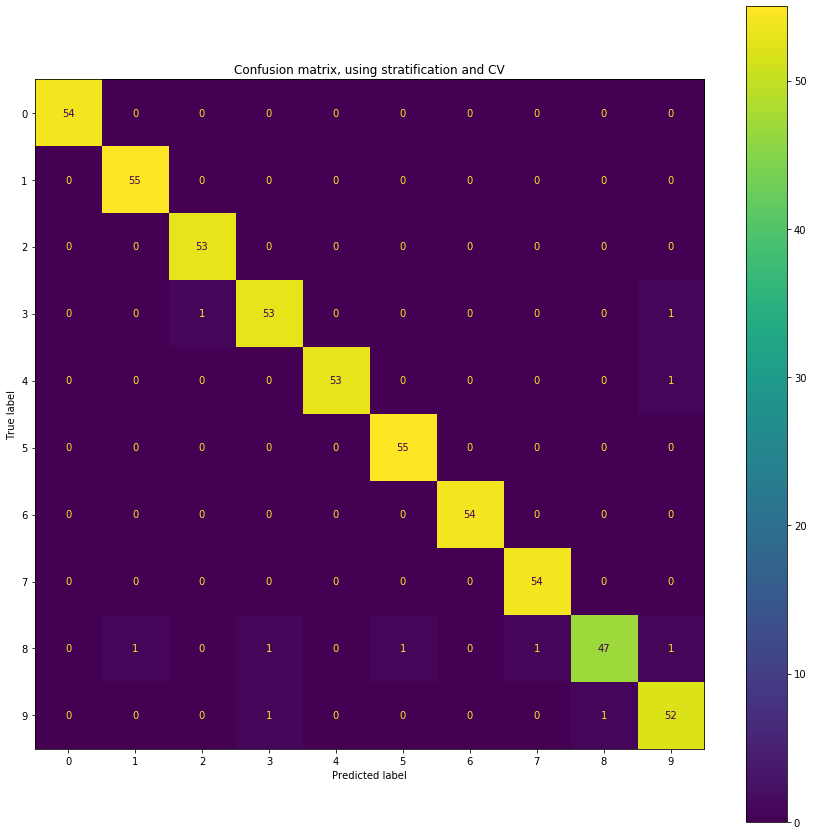

------------------------
Best Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy StratifiedCV: 0.9814814814814815
f1Score StratifiedCV: 0.9811880885273665
recall StratifiedCV: 0.9811926961926962
precision StratifiedCV: 0.9815842953342953
Ocurrencias StratifiedCV: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [27]:
KNN_Stratified_CV(1, 0.3, 13, [3,5,7], ['uniform', 'distance'], [1,2,3,4], 5)

In [28]:
#Function for KNN without Stratification
def KNN_Non_Stratified(X, y, test_size, random_state, n_neighbors, weights, p, n_splits): 
   sss = ShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state)
   for train_index, test_index in sss.split(X, y):
         X_train, X_test = X[train_index], X[test_index]
         y_train, y_test = y[train_index], y[test_index]
        
   miModelo = KNeighborsClassifier(n_neighbors = n_neighbors, p = p)
   miModelo.fit(X_train,y_train)
   y_pred = miModelo.predict(X_test)
    
   #plot confusion matrix
   fig,ax = plt.subplots(figsize = (15,15))
   disp = plot_confusion_matrix(miModelo, X_test, y_test, ax = ax)
    
   #plot confusion matrix
   disp.ax_.set_title("Confusion matrix, without Stratification and CV")
   
   
   
   accuracyNonStratified = accuracy_score(y_test, y_pred)
   f1ScoreNonStratified = f1_score(y_test, y_pred, average = 'macro')
   recallNonStratified  = recall_score(y_test, y_pred,average = 'macro')
   precisionNonStratified = precision_score(y_test, y_pred, average = 'macro')
      
   ocurrenciasNonStratified = collections.Counter(y_train)
    
   print("------------------------")
   print("Accuracy Non Stratified: "+ str(accuracyNonStratified))
   print("f1Score Non Stratified: "+ str(f1ScoreNonStratified))
   print("recallNon Stratified: "+ str(recallNonStratified))
   print("precision Non Stratified: "+ str(precisionNonStratified))
   print("Ocurrencias Non Stratified: " + str(ocurrenciasNonStratified))
   print("------------------------")

As we can see on the next figure, where it is represented a confusion matrix without stratification and without crossvalidation, score results are really good, but if we analyze the number of samples of every category that were used for the training, we have some differences between categories. For example, we have that the training set has 137 samples of the category 0, and 117 samples of the category 3. It is very recommendable to have similar number of samples of every category.

------------------------
Accuracy Non Stratified: 0.9888888888888889
f1Score Non Stratified: 0.9892106369622423
recallNon Stratified: 0.989150350689442
precision Non Stratified: 0.9894468852646124
Ocurrencias Non Stratified: Counter({0: 137, 1: 130, 4: 129, 9: 129, 7: 129, 6: 125, 5: 121, 8: 121, 2: 119, 3: 117})
------------------------


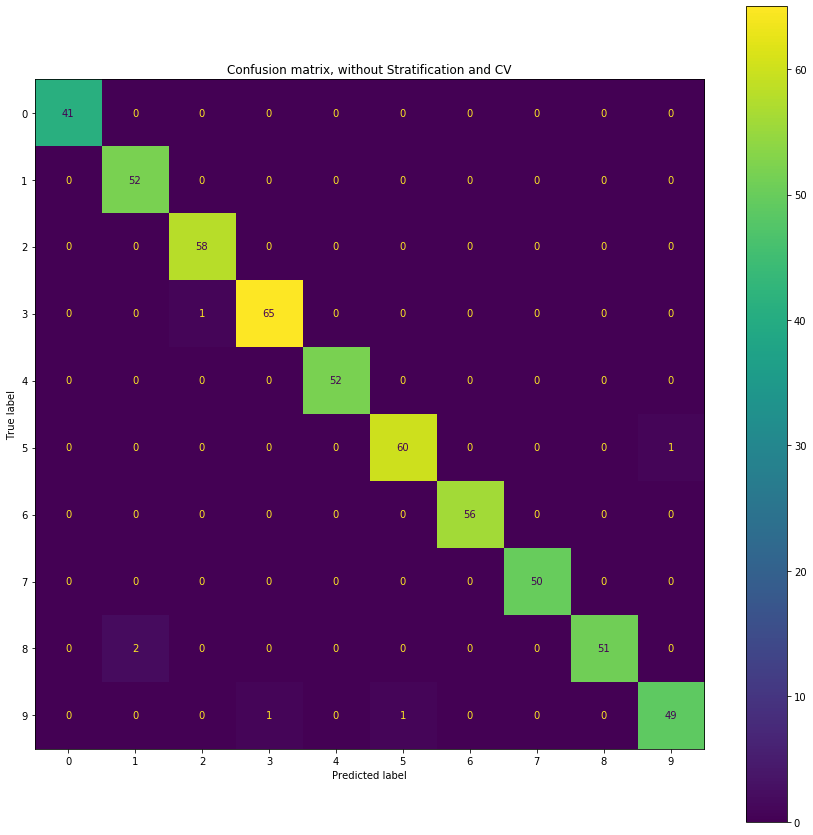

In [29]:
KNN_Non_Stratified(X, y, 0.3, 13, 3, 'uniform', 2, 1)

In [30]:
def KNN_Stratified(X,y, n_splits, test_size, random_state, n_neighbors,weights, p):
     sss = StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size, random_state=random_state)
     for train_index, test_index in sss.split(X, y):
         X_train, X_test = X[train_index], X[test_index]
         y_train, y_test = y[train_index], y[test_index]
        
     miModelo = KNeighborsClassifier(n_neighbors = n_neighbors, p = p)
     miModelo.fit(X_train,y_train)
    
     y_pred = miModelo.predict(X_test)
               
      #plot confusion matrix
     fig,ax = plt.subplots(figsize = (15,15))
     disp = plot_confusion_matrix(miModelo, X_test, y_test, ax = ax)
    
     #plot confusion matrix
     disp.ax_.set_title("Confusion matrix using stratification")
        
     accuracyStratified = accuracy_score(y_test, y_pred)
     f1ScoreStratified  = f1_score(y_test, y_pred,average = 'macro')
     recallStratified  = recall_score(y_test, y_pred,average = 'macro')
     precisionStratified  = precision_score(y_test, y_pred, average = 'macro')
     specifityStratified  = accuracyStratified  - recallStratified 
      
     ocurrenciasStratified = collections.Counter(y_train)
    
     print("------------------------")
     print("Accuracy Stratified: "+ str(accuracyStratified))
     print("f1Score Stratified : "+ str(f1ScoreStratified))
     print("recall Stratified : "+ str(recallStratified))
     print("precision Stratified : "+ str(precisionStratified))
     print("Ocurrencias Stratified: " + str(ocurrenciasStratified))
     print("------------------------")
     

In the next figure we have a confusion matrix using a stratification. As we can see the score results are really good and in contradisctinction  to the KNN used with non stratification, the number of samples per category are very similar each other.

------------------------
Accuracy Stratified: 0.9814814814814815
f1Score Stratified : 0.9811880885273665
recall Stratified : 0.9811926961926962
precision Stratified : 0.9815842953342953
Ocurrencias Stratified: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


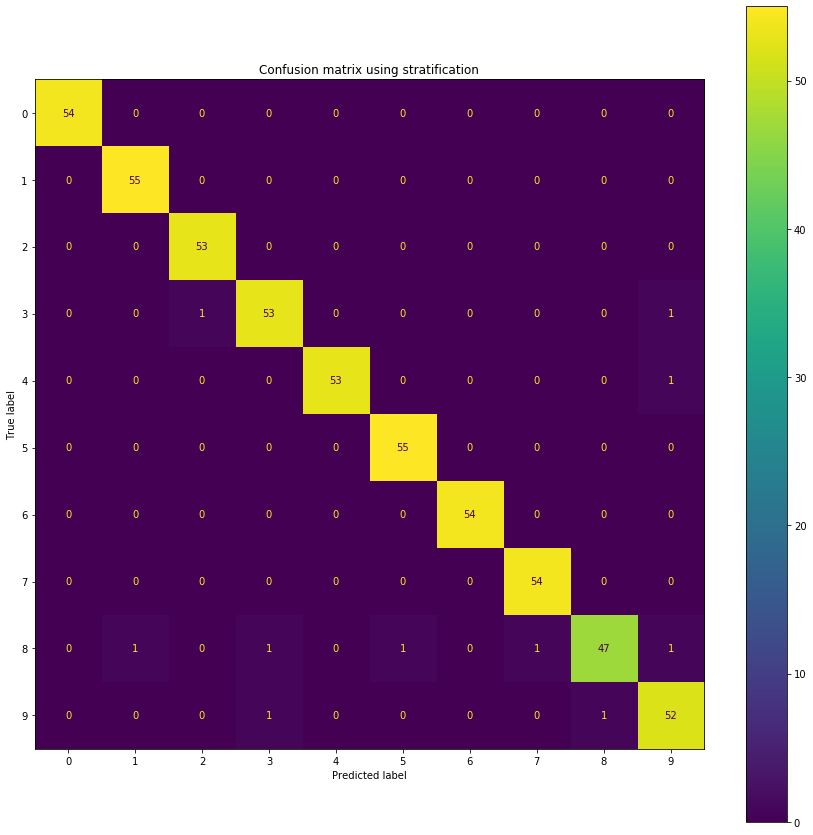

In [31]:
KNN_Stratified(X,y,1, 0.3, 13, 3,'uniform',2)

If we reduce the number of rows of X and y, in this case to 100, and then we run the stratified function, we can see that score results are not bad and the samples per category are really closed each other, from 8 samples for the category 3 to 6 samples for the category 8, in conclusion they maintain similar appearances.

In [32]:
X_reduced = X[0:100]
y_reduced = y[0:100]

------------------------
Accuracy Stratified: 0.9666666666666667
f1Score Stratified : 0.9657142857142856
recall Stratified : 0.9666666666666666
precision Stratified : 0.975
Ocurrencias Stratified: Counter({3: 8, 0: 8, 6: 8, 1: 8, 7: 7, 2: 7, 9: 6, 4: 6, 5: 6, 8: 6})
------------------------


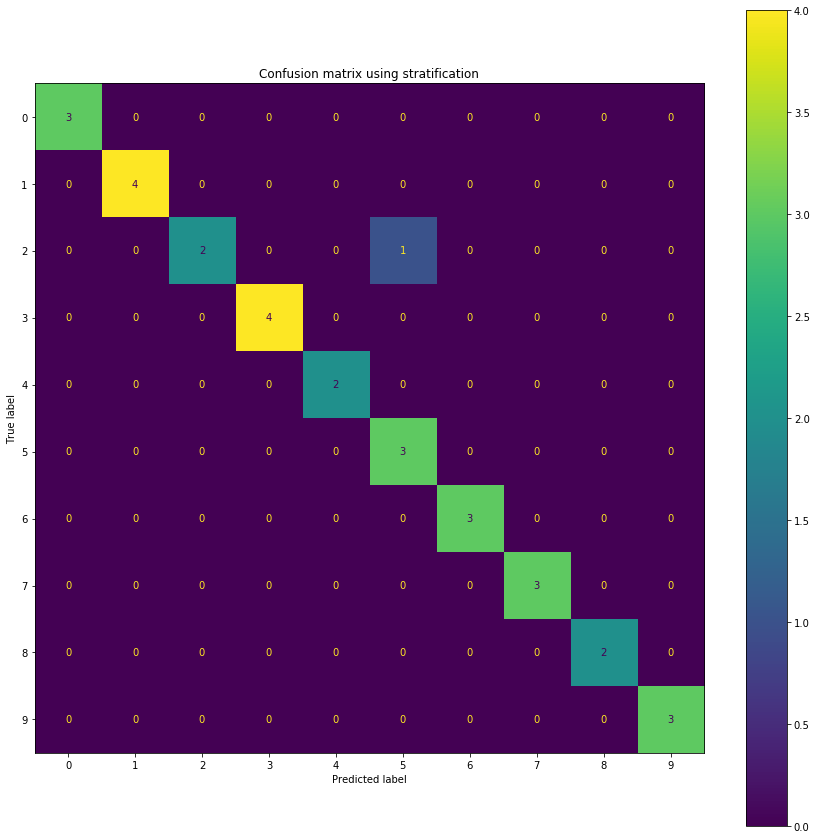

In [33]:
KNN_Stratified(X_reduced,y_reduced,1, 0.3, 13, 3,'uniform',2)

If we run the non stratified function, we can see that results are much worse in comparison to the stratified one and the samples of categories are not close to each other, for example, we have 11 samples of the category 6 and 3 samples of the category 4.

------------------------
Accuracy Non Stratified: 0.9
f1Score Non Stratified: 0.8847442680776014
recallNon Stratified: 0.9333333333333333
precision Non Stratified: 0.8796296296296295
Ocurrencias Non Stratified: Counter({6: 11, 1: 9, 0: 9, 7: 8, 5: 8, 2: 7, 8: 6, 3: 5, 9: 4, 4: 3})
------------------------


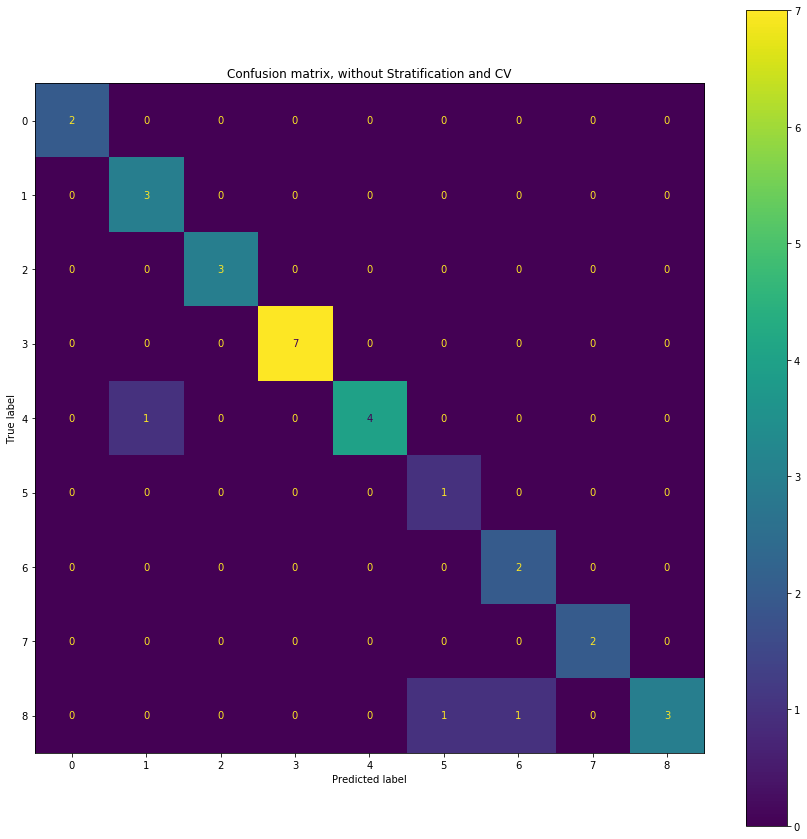

In [34]:
KNN_Non_Stratified(X_reduced, y_reduced, 0.3, 13, 3, 'uniform', 2, 1)

## 6) Include in the set of hyper-parameters adjusted via cross-validation process the weights of the distance metric between samples according to the “weights” parameter of the model in Scikit-learn. Compute the model’s performance when distance metric weights are fine-tuned within cross-validation with respect to only tuning the number of neighbors (K).

In the next figure there is a confusion matrix using a KNN Stratified corssvalidation, where the crossvalidated parameter is the number of neighbors, weigths is set to "uniform" which is the default value and "p" to 2, which is also a default value.

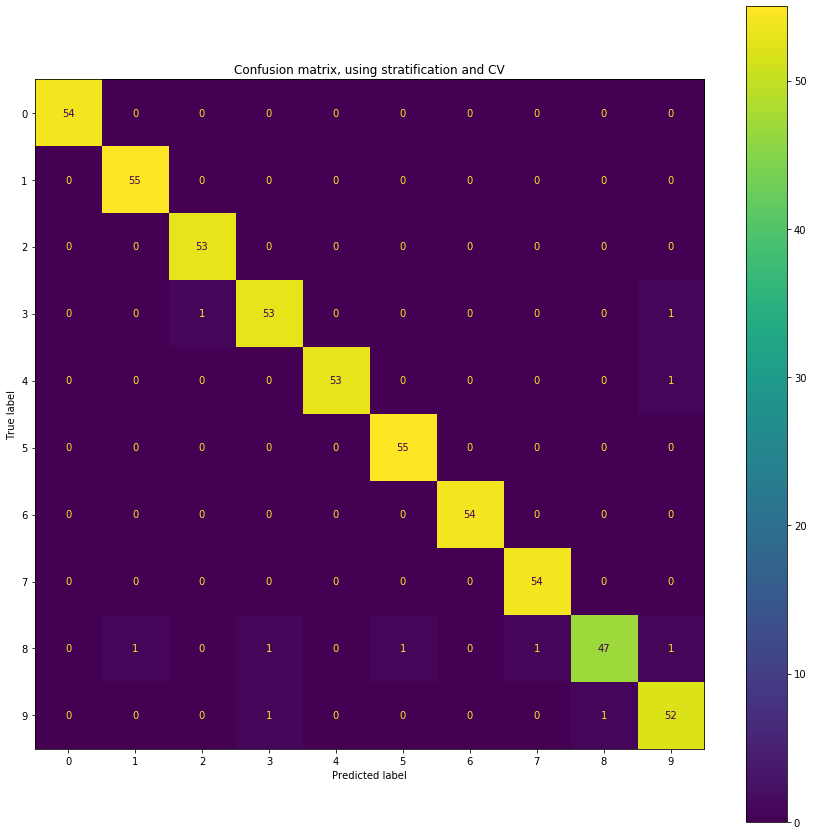

------------------------
Best Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy StratifiedCV: 0.9814814814814815
f1Score StratifiedCV: 0.9811880885273665
recall StratifiedCV: 0.9811926961926962
precision StratifiedCV: 0.9815842953342953
Ocurrencias StratifiedCV: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [35]:
#KNN_Stratified_CV(n_splits, test_size, random_state, n_neighbors, weights, p, cv):
KNN_Stratified_CV(1, 0.3, 13, [3,5,7], ['uniform'], [2], 5)

In the next figure there is a confusion matrix using a KNN Stratified crossvalidation, where the crossvalidated parameter is the number of neighbors, weights nd "p" to 2, which is it default value. The results in this case are the same to not including weights to the crossvalidation, it is like this because the default weights parameter is the best option.

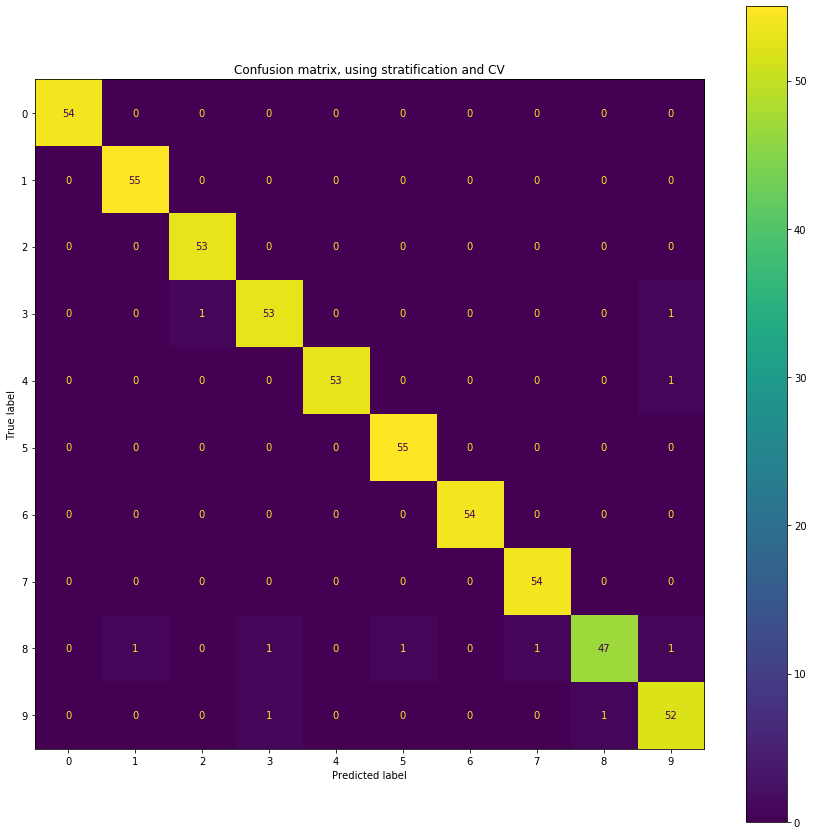

------------------------
Best Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy StratifiedCV: 0.9814814814814815
f1Score StratifiedCV: 0.9811880885273665
recall StratifiedCV: 0.9811926961926962
precision StratifiedCV: 0.9815842953342953
Ocurrencias StratifiedCV: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [36]:
#KNN_Stratified_CV(n_splits, test_size, random_state, n_neighbors, weights, p, cv):
KNN_Stratified_CV(1, 0.3, 13, [3,5,7], ['uniform', 'distance'], [2], 5)

## 7) Following the same approach as in the last section, enter the type of distance metric (“metric”parameter) within the cross-validation process. Evaluates the results and gains / losses of generalizability of the model.

Setting the number of neighbors to the stratified crossvalidation and other parameters as default as we did in the last step we have another time the following results:

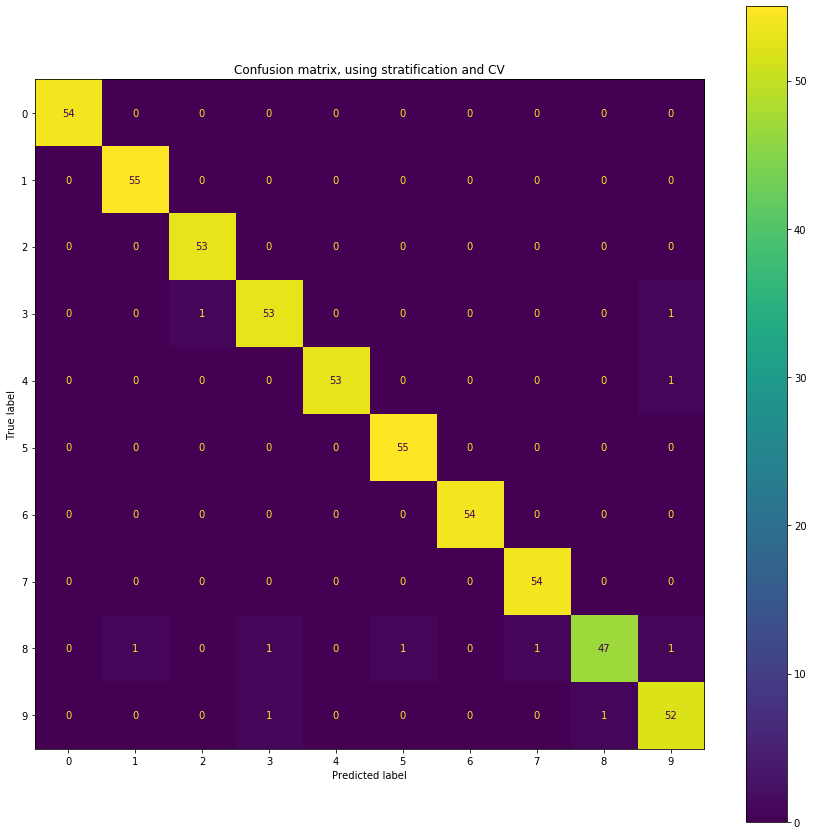

------------------------
Best Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy StratifiedCV: 0.9814814814814815
f1Score StratifiedCV: 0.9811880885273665
recall StratifiedCV: 0.9811926961926962
precision StratifiedCV: 0.9815842953342953
Ocurrencias StratifiedCV: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [37]:
KNN_Stratified_CV(1, 0.3, 13, [3,5,7], ['uniform'], [2], 5)

Setting to the stratified crossvalidation the number of neighbors, weights and p that correspond to the metric Minkowski when it is set to 1 and euclidean when it is set to 2, we have the same results, it is like this because metric, weights, and p are the best settings even when they are in them defaults values, it does not happen with neighbors (default value = 5, best value = 3)  

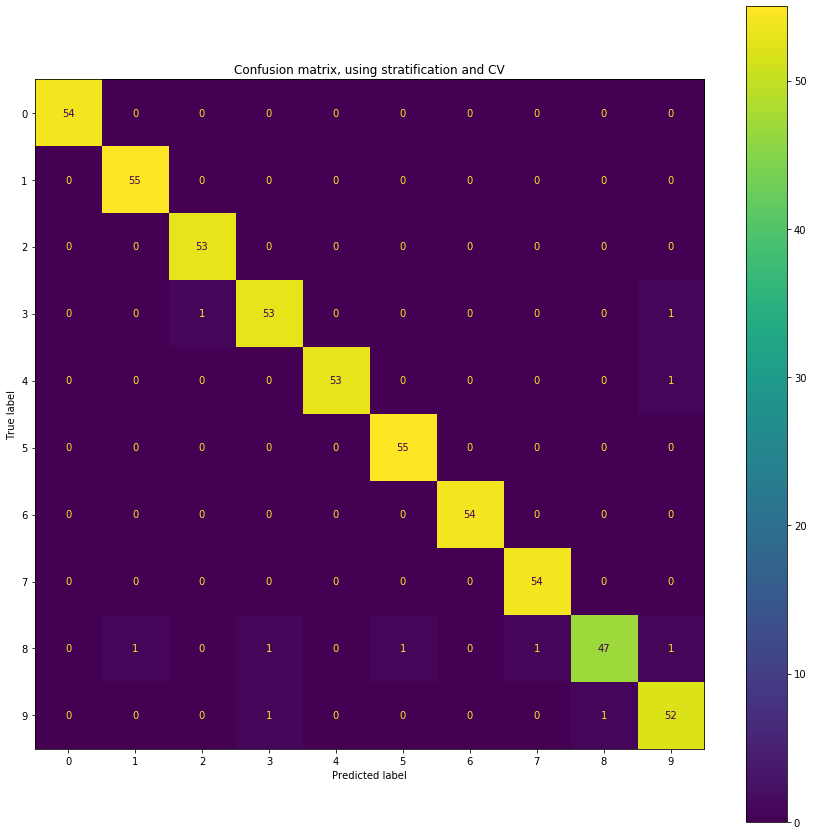

------------------------
Best Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Accuracy StratifiedCV: 0.9814814814814815
f1Score StratifiedCV: 0.9811880885273665
recall StratifiedCV: 0.9811926961926962
precision StratifiedCV: 0.9815842953342953
Ocurrencias StratifiedCV: Counter({3: 128, 6: 127, 1: 127, 5: 127, 4: 127, 9: 126, 7: 125, 2: 124, 0: 124, 8: 122})
------------------------


In [38]:
KNN_Stratified_CV(1, 0.3, 13, [3,5,7], ['uniform', 'distance'], [1,2], 5)